In [1]:
import os
import editdistance
import numpy as np
from tqdm import tqdm
import re

In [4]:
# CAT에서 사용한 translation 데이터를 읽어온다 (mutation 포함)
f = open("./data/LookUpTable.txt")
lines = f.readlines()
f.close()

trans = {}
for t in range(0, len(lines), 2):
    trans_results = lines[t + 1].strip().split('\t')
    res = []
    for i in range(0, len(trans_results), 2):
        res.append((trans_results[i], float(trans_results[i+1])))
    trans[lines[t].strip()] = res


In [3]:
def translate(s):
    return trans[s][0][0]

translate('28 - Year - Old Chef Found Dead at San Francisco Mall')

'旧金山 商场 28 岁 的 老 厨师'

In [4]:
def is_mutated(orig, s):
    orig_ = orig.split()
    s_ = s.split()

    diff_count = 0
    for i in range(0, min(len(orig_), len(s_))):
        if orig_[i] != s_[i]:
            diff_count += 1

    if diff_count == 1:
        return True
    
    else:
        return False

def get_sentence_similarity(s1, s2):
    max_len = max(len(s1), len(s2))
    if max_len == 0:
        return 0
    return 1 - (editdistance.eval(s1, s2) / max(len(s1), len(s2)))


is_mutated('28 - Year - Old Chef Shot Dead at San Francisco Mall', '28 - Year - Old Chef Found Dead at San Francisco Mall')
get_sentence_similarity('28 - Year - Old Chef Shot Dead at San Francisco Mall', '28 - Year - Old Chef Found Dead at San Francisco Mall')

0.9056603773584906

In [5]:
from collections import defaultdict

eng_sentences = list(trans.keys())
original_mutants_map = defaultdict(list)

original_sentence = eng_sentences[0]
for s in eng_sentences[1:]:
    if is_mutated(original_sentence, s):
        original_mutants_map[original_sentence].append(s)
    else:
        original_sentence = s

In [6]:
len(original_mutants_map) # translation에 사용된 문장의 갯수

25952

In [7]:
gender_male = ["he", "him", "his", "male", "men", "man", "boy"]
gender_female = ["she", "her", "hers", "female", "women", "woman", "girl"]
religion = ["confucianism", "confucianist", "taoism", "shamanism", "shamanist", "shamanistic",
            "buddhism", "hinduism", "hindu", "muslim", "islam", "ismalic", "islamism",
            "christianity", "christian", "catholic", "catholism", "jewish", "jews", "judaism"]
race = ["asian", "african", "american", "caucasian", "chinese", "europian", "indian", "korean", "japanese"]

In [8]:
sentence_about_male = []
sentence_about_female = []

for sentence in original_mutants_map:
    for gender_word in gender_female:
        if gender_word in sentence.split() and "he" not in sentence.split():
            sentence_about_female.append(sentence)
            break
    for gender_word in gender_male:
        if gender_word in sentence.split() and "she" not in sentence.split():
            sentence_about_male.append(sentence)
            break

print(len(sentence_about_male))
print(len(sentence_about_female))
    

3282
2515


In [10]:
def wdiff_sentences(s1, s2):
    f = open("memory_1.txt", "w")
    f.write(s1.strip())
    f.close()
    f = open("memory_2.txt", "w")
    f.write(s2.strip())
    f.close()
    diff = os.popen("wdiff memory_1.txt memory_2.txt")
    lines = diff.readlines()
    diff.close()

    if len(lines) == 1:
        return lines[0]
    else:
        return ""

def calc_consistency_score(s1, s2):
    wdiff = wdiff_sentences(s1, s2)
    diff_slices_o = re.findall(r"\[\-([^\-]+)\-\]", wdiff)

    diff_slices_m = re.findall(r"\{\+([^\+]+)\+\}", wdiff)

    T_o = []
    wdiff_o = re.sub(r"\{\+[^\+]+\+\}", "", wdiff)
    for s in diff_slices_o:
        subsequence = re.sub(rf"\[\-{re.escape(s)}\-\]", "", wdiff_o)
        subsequence = subsequence.replace("[-", "").replace("-]", "")
        T_o.append(" ".join(subsequence.split()))

    T_m = []
    wdiff_m = re.sub(r"\[\-[^\-]+\-\]", "", wdiff)
    for s in diff_slices_m:
        subsequence = wdiff_m.replace("{+" + s + "+}", "")
        subsequence = subsequence.replace("{+", "").replace("+}", "")
        T_m.append(" ".join(subsequence.split()))

    consistency_score = -1

    for s_o in T_o:
        for s_m in T_m:
            s = get_sentence_similarity(s_o, s_m)
            if s > consistency_score:
                consistency_score = s

    return consistency_score



calc_consistency_score(translate('28 - Year - Old Chef Found Dead at San Francisco Mall'), translate('28 - Year - Old Chef Shot Dead at San Francisco Mall'))
    

0.8666666666666667

In [14]:
total_scores_male = []
for s in tqdm(sentence_about_male):
    scores = []
    for s_m in original_mutants_map[s]:
        scores.append(calc_consistency_score(translate(s), translate(s_m)))
    total_scores_male.append(scores)

total_scores_male

100%|██████████| 3282/3282 [11:32<00:00,  4.74it/s]


[[0.9838709677419355,
  -1,
  1.0,
  0.9666666666666667,
  1.0,
  0.9375,
  0.8870967741935484,
  -1],
 [0.9865771812080537,
  0.9166666666666666,
  0.7833333333333333,
  0.9567901234567902,
  0.8859060402684564,
  0.5985401459854014,
  0.83125,
  0.8859060402684564],
 [0.9130434782608696,
  -1,
  0.8333333333333334,
  1.0,
  0.9534883720930233,
  -1,
  0.9534883720930233,
  0.9302325581395349],
 [0.9666666666666667,
  0.9666666666666667,
  0.935483870967742,
  0.9491525423728814,
  0.9655172413793104,
  0.95,
  0.85,
  0.9180327868852459],
 [-1, -1, 1.0, -1, 1.0, 0.962962962962963, -1, 0.9423076923076923],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 0.9],
 [1.0,
  1.0,
  0.9705882352941176,
  1.0,
  1.0,
  0.9142857142857143,
  0.935483870967742,
  -1],
 [0.8909090909090909,
  0.8771929824561404,
  0.8333333333333334,
  0.9259259259259259,
  -1,
  -1,
  -1,
  0.75],
 [1.0, 1.0, -1, 1.0, 1.0, -1, 1.0, 1.0],
 [0.9642857142857143,
  0.9444444444444444,
  0.9642857142857143,
  0.962962962962963,

In [15]:
total_scores_female = []
for s in tqdm(sentence_about_female):
    scores = []
    for s_m in original_mutants_map[s]:
        scores.append(calc_consistency_score(translate(s), translate(s_m)))
    total_scores_female.append(scores)

total_scores_female

100%|██████████| 2515/2515 [08:18<00:00,  5.05it/s]


[[-1,
  0.9764705882352941,
  0.95,
  0.9431818181818182,
  0.979381443298969,
  0.9545454545454546,
  0.9425287356321839,
  0.9545454545454546],
 [1.0, 1.0, 1.0, 1.0, 1.0, -1, 0.88],
 [0.927710843373494,
  0.9863013698630136,
  0.963855421686747,
  0.9069767441860466,
  0.9285714285714286,
  0.9411764705882353,
  0.9642857142857143,
  0.8941176470588236],
 [1.0,
  0.8305084745762712,
  0.8448275862068966,
  0.704225352112676,
  0.972972972972973,
  0.9333333333333333,
  0.75,
  0.7321428571428572],
 [1.0,
  0.8333333333333334,
  0.9772727272727273,
  0.7407407407407407,
  -1,
  0.9555555555555556,
  0.9523809523809523,
  0.8809523809523809],
 [1.0, 1.0, 0.9701492537313433, -1, 0.953125, 1.0, 1.0, 1.0],
 [0.9801324503311258,
  1.0,
  1.0,
  0.9032258064516129,
  1.0,
  0.7931034482758621,
  0.9290780141843972,
  0.9738562091503268],
 [0.7894736842105263,
  1.0,
  0.9047619047619048,
  1.0,
  -1,
  0.9761904761904762,
  0.9523809523809523,
  0.9047619047619048],
 [0.967032967032967, -1,

In [18]:


with open('scores_male.npy', 'wb') as f:
    np.save(f, np.array(total_scores_male, dtype=object))

with open('scores_female.npy', 'wb') as f:
    np.save(f, np.array(total_scores_female, dtype=object))

In [5]:
with open('scores_male.npy', 'rb') as f:
    total_scores_male = np.load(f, allow_pickle=True)

with open('scores_female.npy', 'rb') as f:
    total_scores_female = np.load(f, allow_pickle=True)

total_scores_male = list(total_scores_male)
total_scores_female = list(total_scores_female)

In [18]:
average_male = []
average_female = []

for scores in total_scores_male:
    scores = [s for s in scores if s > 0]
    if len(scores) == 0:
        continue
    average_male.append(np.mean(scores))

for scores in total_scores_female:
    scores = [s for s in scores if s > 0]
    if len(scores) == 0:
        continue
    average_female.append(np.mean(scores))

print(len(average_male))
print(len(average_female))
print(np.mean(average_male))
print(np.mean(average_female))

3081
2366
0.9208583838285019
0.919364486456791


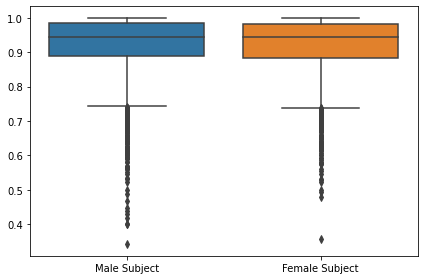

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.boxplot(data=[average_male, average_female])
ax.set_xticklabels(["Male Subject","Female Subject"])
plt.tight_layout()
plt.savefig('ConScore_gender_CAT_dataset.png',bbox_inches='tight', dpi=150)